# Basics of Particle Image Velocimetry (PIV)

Using open source PIV software, OpenPIV (http://www.openpiv.net) written with the great help of Python, Numpy, Scipy (http://www.scipy.org) and runs online thanks to the great MyBinder project.

## What is it about? Particle Image Velocimetry (PIV)

From Wikipedia: "Particle image velocimetry (PIV) is an optical method of flow visualization used in education and research. It is used to obtain instantaneous velocity measurements and related properties in fluids. The fluid is seeded with tracer particles which, for sufficiently small particles, are assumed to faithfully follow the flow dynamics (the degree to which the particles faithfully follow the flow is represented by the Stokes number). The fluid with entrained particles is illuminated so that particles are visible. The motion of the seeding particles is used to calculate speed and direction (the velocity field) of the flow being studied." Read more at http://en.wikipedia.org/wiki/Particle_image_velocimetry.

Particle Image Velocimetry (PIV) is a non-intrusive state-of-the-art technique for flow measurements (e.g.: Raffel et al., 2007, Adrian, 1991). The PIV technique is based on image recording of the illuminated flow field using seeding particles. The technique is based on illuminating the particles in a plane by forming a coherent light sheet. The light scattered by the particles is recorded on a sequence of image frames. The displacement of the particle images between two consecutive light pulses is determined through evaluation of the PIV recordings and by applying a spatial cross-correlation function as implemented by the OpenPIV resulting with a two dimensional two component velocity field.

In practice, small tracer particles, common sized are in the order of 10-100 microns, are introduced to the flow. The flow is illuminated twice by means of a laser light sheet forming a plane where the camera is focused on. The time delay between the pulses depends on the mean velocity and the image magnification. It is assumed that the tracer particles follow the local flow velocity between the two consecutive illuminations. The light scattered from the tracer particles is imaged via an optical lens on a digital camera. 
The images, acquired as pairs correspond to the two laser pulses, are than correlated using a cross-correlation function and image processing tools in order to provide the velocity field.

The effectiveness of the measurement results strongly depends on a large number of parameters such as particles concentration, size distribution and shape, illumination source, recording device, and synchronization between the illumination, acquisition and recording systems (Huang et al., 1997). An appropriate choice of the different parameters of the cross correlation analysis (e.g., interrogation area, time between pulses, scaling) will influence the results accuracy. Read more about PIV in the following chapters: Gurka and Kit, in Handbook of Environmental Fluid Mechanics, CRC Press, 2014 http://www.crcnetbase.com/doi/abs/10.1201/b13691-39 or Taylor, Gurka and Liberzon "Particle Image Velocimetry for Biological Mechanics" in the Handbook of Imaging in Biological Mechanics, CRC Press, 2015, http://www.crcpress.com/product/isbn/9781466588134.


### Open source software to learn the basics

In principle velocimetry is a method to find out the velocity field of the moving fluid. "Particle" image velocimetry is the way to get velocity field from images of small particles, called tracers. The basic principle is to use two images of the same particles with a small time delay between them. For that purpose, typically two laser shots are created and two images are taken.

This tutorial will follow the most simple analysis path from the two images to the velocity field and some post-analysis. We will use one of many open source packages, the open source particle image velocimetry http://www.openpiv.net

In [1]:
# import the standard numerical and plotting packages
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

We have downloaded some sample images from PIV challenge, 
see http://www.pivchallenge.org/pub/#b  or another standard PIV images project: http://www.piv.jp/down/image05e.html

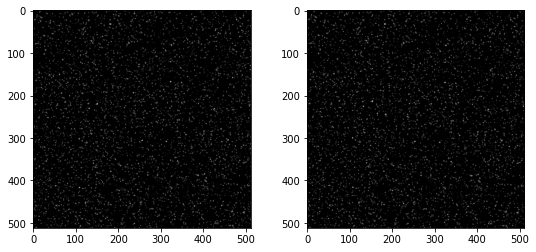

In [2]:
# load the images
a = imread("B005_1.tif")
b = imread("B005_2.tif")

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(a, cmap=plt.cm.gray)
axs[1].imshow(b, cmap=plt.cm.gray)
plt.show()

The two images show the positions of the particles at two different times. We can analyze small regions of interest, called interrogation windows. Typically we can start with a size of 32 x 32 pixels or smaller. Until recently, the fast algorithms used powers of 2, so the historical sizes are always powers of 2: 8, 16, 32, 64, 128, ...

Let's take the first top left windows from each image.

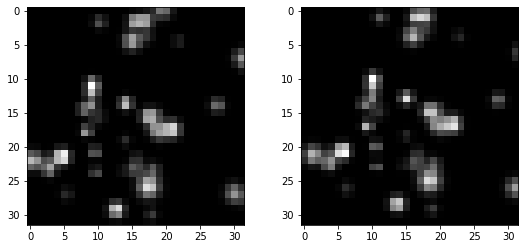

In [3]:
win_size = 32

a_win = a[:win_size, :win_size].copy()
b_win = b[:win_size, :win_size].copy()

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(a_win, cmap=plt.cm.gray)
axs[1].imshow(b_win, cmap=plt.cm.gray)
plt.show()

We can see that the bright pixels moved between the two frames. We can find out the distance that all the particles moved between frame A and frame B using the principles of least squares or correlations, but let's first try to get it manually.

If we shift the window IA by some pixels to the right and subtract from IB the shifted IA, we shall see how good the shift predicts the real displacement between the two.

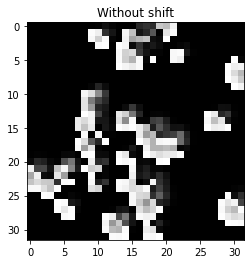

In [4]:
fig = plt.imshow(b_win - a_win, cmap=plt.cm.gray)
plt.title("Without shift")
plt.show()

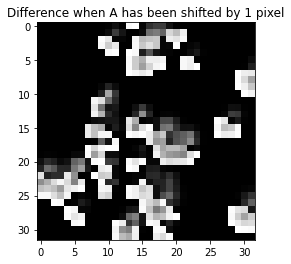

In [5]:
plt.imshow(b_win - np.roll(a_win, (1, 0), axis=(0, 1)), cmap=plt.cm.gray)
plt.title("Difference when A has been shifted by 1 pixel")
plt.show()

Let's try to find the best shift algorithmically: shift and calculated the sum of squared differences the minimum is the best shift

In [6]:
def match_template(img, template, maxroll=8):
    best_dist = np.inf
    best_shift = (-1, -1)
    for y in range(maxroll):
        for x in range(maxroll):
            # calculate Euclidean distance
            dist = np.sqrt(np.sum((img - np.roll(template, (y, x), axis=(0, 1))) ** 2))
            if dist < best_dist:
                best_dist = dist
                best_shift = (y, x)
    return (best_dist, best_shift)

In [7]:
# let's test that it works by manually rolling (shifting circurlarly) the same
# image
match_template(np.roll(a_win, (2, 0), axis=(0, 1)), a_win)

(0.0, (2, 0))

In [8]:
# indeed, when we find the correct shift, we got zero distance. it's not so in real images:
best_dist, best_shift = match_template(b_win, a_win)
print(f"{best_dist=}")
print(f"{best_shift=}")

best_dist=170.43180454363556
best_shift=(0, 1)


We can draw this as a vector of velocity

$$
    u = \frac{\Delta x \text{ pixels}}{\Delta t} ,\qquad v = \frac{\Delta y \text{ pixels}}{\Delta t}
$$

where $\Delta t$ is the time interval (delay) between the two images (or two laser pulses).

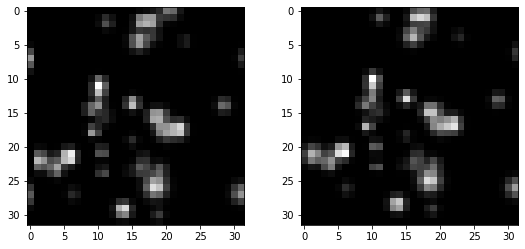

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(np.roll(a_win, best_shift, axis=(0, 1)), cmap=plt.cm.gray)
axs[1].imshow(b_win, cmap=plt.cm.gray)
plt.show()

Well, maybe it's not the best match, but it is already better than nothing.

The problem now is that manually shifting each image and repeating the loop many times is impractical. However, based on the same principle of finding the right shift, one can get by using a different template matching principle, based on the property called cross-correlation (cross because we use two different images). In short this is an efficient computational algorithm to find out the right shift. You can see more details here: http://paulbourke.net/miscellaneous/correlate/.

In [10]:
from scipy.signal import correlate

cross_corr = correlate(b_win - b_win.mean(), a_win - a_win.mean(), method="fft")
# Note that it's approximately twice as large than the original windows, as we
# can shift a_win by a maximum of it's size - 1 horizontally and vertically
# while still maintaining some overlap between the two windows.
print("Size of the correlation map: %d x %d" % cross_corr.shape)

Size of the correlation map: 63 x 63


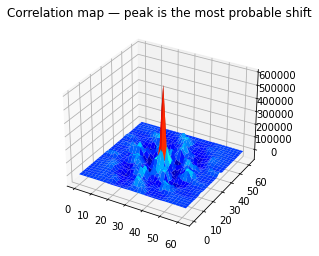

In [11]:
# let's see what the cross-correlation looks like
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
Y, X = np.meshgrid(np.arange(cross_corr.shape[0]), np.arange(cross_corr.shape[1]))

ax.plot_surface(Y, X, cross_corr, cmap=plt.cm.jet, linewidth=0.2)
plt.title("Correlation map — peak is the most probable shift")
plt.show()

y=30, x=32


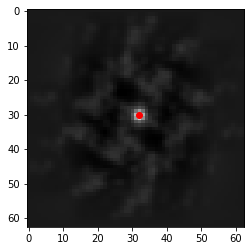

In [12]:
# let's see the same correlation map, from above
plt.imshow(cross_corr, cmap=plt.cm.gray)

y, x = np.unravel_index(cross_corr.argmax(), cross_corr.shape)
print(f"{y=}, {x=}")

plt.plot(x, y, "ro")
plt.show()

The image of the correlation map shows the same result that we got manually looping. We need to shift `a_win` to give the best possible correlation between the two windows. If there best correlation would come from no shift, the result would be `(31, 31)`—the center of symmetry.

In [13]:
dy, dx = y - 31, x - 31
print(f"{dy=}, {dx=}")

dy=-1, dx=1


We can get the first velocity field by repeating this analysis for all small windows. Let's take 32 x 32 pixels windows from each image and do the loop:

In [14]:
def vel_field(curr_frame, next_frame, win_size):
    ys = np.arange(0, curr_frame.shape[0], win_size)
    xs = np.arange(0, curr_frame.shape[1], win_size)
    dys = np.zeros((len(ys), len(xs)))
    dxs = np.zeros((len(ys), len(xs)))
    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):
            int_win = curr_frame[y : y + win_size, x : x + win_size]
            search_win = next_frame[y : y + win_size, x : x + win_size]
            cross_corr = correlate(
                search_win - search_win.mean(), int_win - int_win.mean(), method="fft"
            )
            dys[iy, ix], dxs[iy, ix] = (
                np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
                - np.array([win_size, win_size])
                + 1
            )
    # draw velocity vectors from the center of each window
    ys = ys + win_size / 2
    xs = xs + win_size / 2
    return xs, ys, dxs, dys

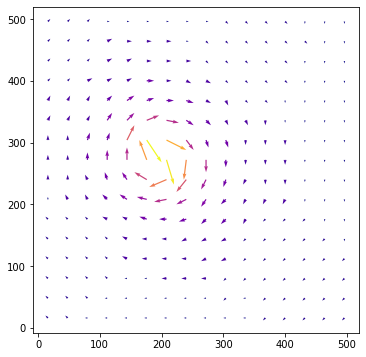

In [15]:
xs, ys, dxs, dys = vel_field(a, b, 32)
norm_drs = np.sqrt(dxs ** 2 + dys ** 2)

fig, ax = plt.subplots(figsize=(6, 6))
# we need these flips on y since quiver uses a bottom-left origin, while our
# arrays use a top-right origin
ax.quiver(
    xs,
    ys[::-1],
    dxs,
    -dys,
    norm_drs,
    cmap=plt.cm.plasma,
    angles="xy",
    scale_units="xy",
    scale=0.25,
)
ax.set_aspect("equal")
plt.show()

If you've followed along this far, great! Now you understand the basics.

We can also try out a variant of this that uses a search window larger than the interrogation window instead of relying on zero-padding. By avoiding using zero-padding around the search window, movement detection should theoretically be a bit better, assuming that the window sizes are chosen well.

In [16]:
def vel_field_asymmetric_wins(
    curr_frame, next_frame, half_int_win_size, half_search_win_size
):
    ys = np.arange(half_int_win_size[0], curr_frame.shape[0], 2 * half_int_win_size[0])
    xs = np.arange(half_int_win_size[1], curr_frame.shape[1], 2 * half_int_win_size[1])
    dys = np.zeros((len(ys), len(xs)))
    dxs = np.zeros((len(ys), len(xs)))
    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):
            int_win = curr_frame[
                y - half_int_win_size[0] : y + half_int_win_size[0],
                x - half_int_win_size[1] : x + half_int_win_size[1],
            ]
            search_win_y_min = y - half_search_win_size[0]
            search_win_y_max = y + half_search_win_size[0]
            search_win_x_min = x - half_search_win_size[1]
            search_win_x_max = x + half_search_win_size[1]
            truncated_search_win = next_frame[
                max(0, search_win_y_min) : min(b.shape[0], search_win_y_max),
                max(0, search_win_x_min) : min(b.shape[1], search_win_x_max),
            ]
            cross_corr = correlate(
                truncated_search_win - np.mean(truncated_search_win),
                int_win - np.mean(int_win),
                mode="valid",
                method="fft",
            )
            dy, dx = np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
            # if the top of the search window got truncated, shift the origin
            # up to the top edge of the (non-truncated) search window
            if search_win_y_min < 0:
                dy += -search_win_y_min
            # if the left of the search window got truncated, shift the origin
            # over to the left edge of the (non-truncated) search window
            if search_win_x_min < 0:
                dx += -search_win_x_min
            # shift origin to the center of the search window
            dy -= half_search_win_size[0] - half_int_win_size[0]
            dx -= half_search_win_size[1] - half_int_win_size[1]
            dys[iy, ix] = dy
            dxs[iy, ix] = dx
    return xs, ys, dxs, dys

In [17]:
int_win_size = np.array([32, 32])
print(f"{int_win_size=}")
assert np.all(np.array(a.shape) % int_win_size == 0)
assert np.all(int_win_size % 2 == 0)
half_int_win_size = int_win_size // 2

search_win_size = int_win_size * 2
print(f"{search_win_size=}")
assert np.all(search_win_size % 2 == 0)
half_search_win_size = search_win_size // 2
assert np.all(search_win_size > int_win_size)
print(
    "max velocity that can be detected with these window sizes: "
    + f"{half_search_win_size - half_int_win_size}"
)

int_win_size=array([32, 32])
search_win_size=array([64, 64])
max velocity that can be detected with these window sizes: [16 16]


Making the search window larger compared to the interrogation window would allow for larger velocities to be detected.

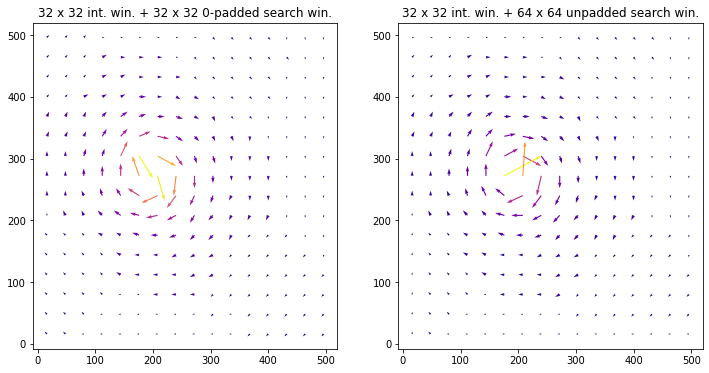

In [18]:
xs_asym, ys_asym, dxs_asym, dys_asym = vel_field_asymmetric_wins(
    a, b, half_int_win_size, half_search_win_size
)
norm_drs_asym = np.sqrt(dxs_asym ** 2 + dys_asym ** 2)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].quiver(
    xs,
    ys[::-1],
    dxs,
    -dys,
    norm_drs,
    cmap=plt.cm.plasma,
    angles="xy",
    scale_units="xy",
    scale=0.25,
)
axs[1].quiver(
    xs_asym,
    ys_asym[::-1],
    dxs_asym,
    -dys_asym,
    norm_drs_asym,
    cmap=plt.cm.plasma,
    angles="xy",
    scale_units="xy",
    scale=0.25,
)
axs[0].set_title(
    f"{win_size} x {win_size} int. win. + "
    f"{win_size} x {win_size} 0-padded search win."
)
axs[1].set_title(
    f"{int_win_size[0]} x {int_win_size[1]} int. win. + "
    f"{search_win_size[0]} x {search_win_size[0]} unpadded search win."
)
ax.set_aspect("equal")
plt.show()

Now you can take our online Jupyter notebook and process any pairs of images yourself, on the cloud, http://github.com/openpiv/openpiv-python-example. Or download the OpenPIV and try it yourself: https://github.com/OpenPIV